In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Bidirectional

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

2022-06-07 13:52:33.956461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-07 13:52:33.956513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv(r"complaints.csv")
df.head(5)

/tmp/ipykernel_31120/3780562020.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"complaints.csv")


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-05-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Informative Research,GA,31047.0,NaN,NaN,Web,2022-05-25,Closed with explanation,Yes,NaN,5600849
1,2022-05-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"EQUIFAX, INC.",TX,77493.0,NaN,NaN,Web,2022-05-23,In progress,Yes,NaN,5589545
2,2022-05-18,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,AZ,85210.0,NaN,NaN,Web,2022-05-18,In progress,Yes,NaN,5576961
3,2022-05-18,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60123.0,NaN,NaN,Web,2022-05-18,Closed with non-monetary relief,Yes,NaN,5575236
4,2022-05-18,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,77439.0,NaN,Consent not provided,Web,2022-05-18,Closed with non-monetary relief,Yes,NaN,5574166


In [3]:
df = df[['Product','Consumer complaint narrative']]

In [4]:
print(df.shape)
df.dropna(inplace= True)
print(df.shape)

(2693834, 2)
(942863, 2)


In [5]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    394471
Debt collection                                                                 176912
Mortgage                                                                         91969
Credit card or prepaid card                                                      71415
Checking or savings account                                                      45394
Credit reporting                                                                 31588
Student loan                                                                     30813
Money transfer, virtual currency, or money service                               22485
Credit card                                                                      18838
Vehicle loan or lease                                                            17640
Bank account or service                                                          14885
Payday loan, title loan, or personal loan  

In [6]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']


In [7]:
df['Consumer complaint narrative'].isnull().sum()

0

## Text Cleaning

In [8]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)


In [9]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')


/tmp/ipykernel_31120/3170499845.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')


In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 222504 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (942571, 250)


In [12]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (942571, 13)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(848313, 250) (848313, 13)
(94258, 250) (94258, 13)


## LSTM Model

In [14]:
def get_lstm_model(backwards,n_timesteps):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,go_backwards=backwards))
    model.add(Dense(13, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


### LSTM Forward Direction

In [15]:
n_timesteps= 10

# lstm forwards
model_lstm_forw = get_lstm_model(False,n_timesteps)
hist_lstm_forw =  model_lstm_forw.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1)


2022-06-04 09:23:45.355407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-04 09:23:45.356014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-04 09:23:45.356126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-04 09:23:45.356227: W tensorflow/stream_executor

Epoch 1/5
11930/11930 [==============================] - 2628s 220ms/step - loss: 0.6360 - accuracy: 0.7968 - val_loss: 0.4777 - val_accuracy: 0.8401
Epoch 2/5
11930/11930 [==============================] - 2632s 221ms/step - loss: 0.4524 - accuracy: 0.8472 - val_loss: 0.4406 - val_accuracy: 0.8497
Epoch 3/5
11930/11930 [==============================] - 2634s 221ms/step - loss: 0.4035 - accuracy: 0.8621 - val_loss: 0.4348 - val_accuracy: 0.8529
Epoch 4/5
11930/11930 [==============================] - 2652s 222ms/step - loss: 0.3662 - accuracy: 0.8746 - val_loss: 0.4405 - val_accuracy: 0.8522
Epoch 5/5
11930/11930 [==============================] - 2609s 219ms/step - loss: 0.3354 - accuracy: 0.8853 - val_loss: 0.4473 - val_accuracy: 0.8514


### LSTM Backward Direction

In [16]:
# lstm forwards
model_lstm_back = get_lstm_model(True,n_timesteps)
hist_lstm_back =  model_lstm_back.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1)


Epoch 1/5
11930/11930 [==============================] - 2587s 217ms/step - loss: 0.8665 - accuracy: 0.7189 - val_loss: 0.5183 - val_accuracy: 0.8314
Epoch 2/5
11930/11930 [==============================] - 2604s 218ms/step - loss: 0.4844 - accuracy: 0.8398 - val_loss: 0.4631 - val_accuracy: 0.8449
Epoch 3/5
11930/11930 [==============================] - 2611s 219ms/step - loss: 0.4256 - accuracy: 0.8567 - val_loss: 0.4444 - val_accuracy: 0.8505
Epoch 4/5
11930/11930 [==============================] - 2656s 223ms/step - loss: 0.3868 - accuracy: 0.8696 - val_loss: 0.4493 - val_accuracy: 0.8499
Epoch 5/5
11930/11930 [==============================] - 2615s 219ms/step - loss: 0.3566 - accuracy: 0.8799 - val_loss: 0.4551 - val_accuracy: 0.8510


### Bidirectional LSTM : Concat mode

In [27]:
def get_bi_lstm_model(mode,n_timesteps):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2),merge_mode= mode))
    model.add(Dense(13, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [28]:
# bidirectional concat
mode_bilstm_concat = get_bi_lstm_model('concat',n_timesteps)
hist_bilstm_concat =  mode_bilstm_concat.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1)


Epoch 1/5
11930/11930 [==============================] - 2975s 249ms/step - loss: 0.6810 - accuracy: 0.7864 - val_loss: 0.4981 - val_accuracy: 0.8327
Epoch 2/5
11930/11930 [==============================] - 2931s 246ms/step - loss: 0.4619 - accuracy: 0.8448 - val_loss: 0.4458 - val_accuracy: 0.8481
Epoch 3/5
11930/11930 [==============================] - 2933s 246ms/step - loss: 0.4079 - accuracy: 0.8610 - val_loss: 0.4382 - val_accuracy: 0.8516
Epoch 4/5
11930/11930 [==============================] - 2937s 246ms/step - loss: 0.3695 - accuracy: 0.8739 - val_loss: 0.4388 - val_accuracy: 0.8522
Epoch 5/5
11930/11930 [==============================] - 2939s 246ms/step - loss: 0.3375 - accuracy: 0.8850 - val_loss: 0.4527 - val_accuracy: 0.8523


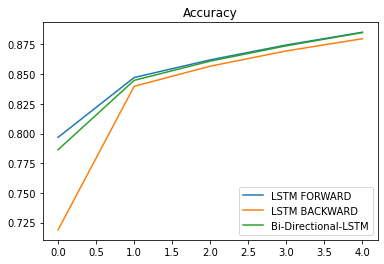

In [31]:
## Accuracy Plot
plt.title('Accuracy')
plt.plot(hist_lstm_forw.history['accuracy'], label='LSTM FORWARD')
plt.plot(hist_lstm_back.history['accuracy'], label='LSTM BACKWARD')
plt.plot(hist_bilstm_concat.history['accuracy'], label='Bi-Directional-LSTM')

plt.legend()
plt.show();


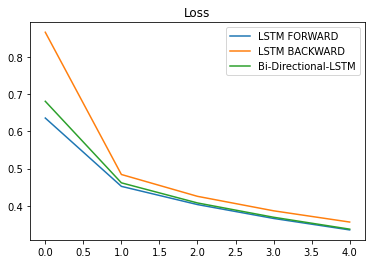

In [32]:
## Loss Plot
plt.title('Loss')
plt.plot(hist_lstm_forw.history['loss'], label='LSTM FORWARD')
plt.plot(hist_lstm_back.history['loss'], label='LSTM BACKWARD')
plt.plot(hist_bilstm_concat.history['loss'], label='Bi-Directional-LSTM')

plt.legend()
plt.show();


### Bidirectional LSTM : Sum mode

In [33]:
# bidirectional concat
mode_bilstm_sum = get_bi_lstm_model('sum',n_timesteps)
hist_bilstm_sum =  mode_bilstm_sum.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1)


Epoch 1/5
11930/11930 [==============================] - 2959s 248ms/step - loss: 0.6701 - accuracy: 0.7902 - val_loss: 0.4972 - val_accuracy: 0.8342
Epoch 2/5
11930/11930 [==============================] - 2960s 248ms/step - loss: 0.4618 - accuracy: 0.8445 - val_loss: 0.4451 - val_accuracy: 0.8491
Epoch 3/5
11930/11930 [==============================] - 2958s 248ms/step - loss: 0.4071 - accuracy: 0.8610 - val_loss: 0.4370 - val_accuracy: 0.8505
Epoch 4/5
11930/11930 [==============================] - 2964s 248ms/step - loss: 0.3685 - accuracy: 0.8737 - val_loss: 0.4396 - val_accuracy: 0.8525
Epoch 5/5
11930/11930 [==============================] - 3008s 252ms/step - loss: 0.3368 - accuracy: 0.8853 - val_loss: 0.4470 - val_accuracy: 0.8515


### Bidirectional LSTM : Multiply mode

In [35]:
# bidirectional Multiply
mode_bilstm_multiply = get_bi_lstm_model('mul',n_timesteps)
hist_bilstm_multiply =  mode_bilstm_multiply.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1)


Epoch 1/5
11930/11930 [==============================] - 2915s 244ms/step - loss: 0.6066 - accuracy: 0.8038 - val_loss: 0.4681 - val_accuracy: 0.8426
Epoch 2/5
11930/11930 [==============================] - 2914s 244ms/step - loss: 0.4420 - accuracy: 0.8502 - val_loss: 0.4361 - val_accuracy: 0.8493
Epoch 3/5
11930/11930 [==============================] - 2912s 244ms/step - loss: 0.3958 - accuracy: 0.8648 - val_loss: 0.4318 - val_accuracy: 0.8521
Epoch 4/5
11930/11930 [==============================] - 2852s 239ms/step - loss: 0.3609 - accuracy: 0.8765 - val_loss: 0.4364 - val_accuracy: 0.8538
Epoch 5/5
11930/11930 [==============================] - 2846s 239ms/step - loss: 0.3319 - accuracy: 0.8865 - val_loss: 0.4510 - val_accuracy: 0.8506


### Bidirectional LSTM : Average mode

In [36]:
# bidirectional Average
mode_bilstm_avg = get_bi_lstm_model('ave',n_timesteps)
hist_bilstm_avg =  mode_bilstm_avg.fit(X_train, Y_train, epochs=5, batch_size=64,validation_split=0.1)


Epoch 1/5
11930/11930 [==============================] - 2951s 247ms/step - loss: 0.7058 - accuracy: 0.7759 - val_loss: 0.4931 - val_accuracy: 0.8357
Epoch 2/5
11930/11930 [==============================] - 2947s 247ms/step - loss: 0.4604 - accuracy: 0.8455 - val_loss: 0.4491 - val_accuracy: 0.8464
Epoch 3/5
11930/11930 [==============================] - 2949s 247ms/step - loss: 0.4097 - accuracy: 0.8607 - val_loss: 0.4380 - val_accuracy: 0.8505
Epoch 4/5
11930/11930 [==============================] - 2946s 247ms/step - loss: 0.3745 - accuracy: 0.8723 - val_loss: 0.4376 - val_accuracy: 0.8526
Epoch 5/5
11930/11930 [==============================] - 2945s 247ms/step - loss: 0.3453 - accuracy: 0.8825 - val_loss: 0.4487 - val_accuracy: 0.8504


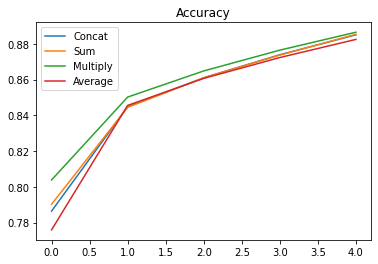

In [38]:
## Accuracy Plot
plt.title('Accuracy')
plt.plot(hist_bilstm_concat.history['accuracy'], label='Concat')
plt.plot(hist_bilstm_sum.history['accuracy'], label='Sum')
plt.plot(hist_bilstm_multiply.history['accuracy'], label='Multiply')
plt.plot(hist_bilstm_avg.history['accuracy'], label='Average')

plt.legend()
plt.show();


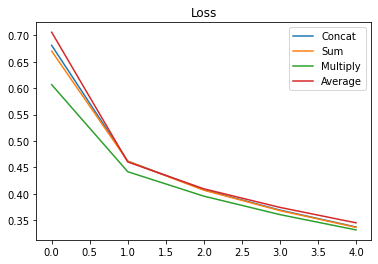

In [40]:
## Loss Plot
plt.title('Loss')
plt.plot(hist_bilstm_concat.history['loss'], label='Concat')
plt.plot(hist_bilstm_sum.history['loss'], label='Sum')
plt.plot(hist_bilstm_multiply.history['loss'], label='Multiply')
plt.plot(hist_bilstm_avg.history['loss'], label='Average')

plt.legend()
plt.show();


LSTM VS BiDirectional LSTM
LSTM Forward: loss: 0.3354 - accuracy: 0.8853
LSTM Backward: loss: 0.3566 - accuracy: 0.8799
BiDirectional LSTM (Conacat): loss: 0.3375 - accuracy: 0.8850
BiDirectional LSTM (Sum): loss: 0.3368 - accuracy: 0.8853
BiDirectional LSTM (Multiply): loss: 0.3319 - accuracy: 0.8865
BiDirectional LSTM (Average): loss: 0.3453 - accuracy: 0.8825

## Testing

In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])
